In [1]:
import torch, time
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_class'].value_counts()

fare_class
0    80000
1    40000
Name: count, dtype: int64

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class'] 

In [11]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    120000 non-null  object        
 1   fare_amount        120000 non-null  float64       
 2   fare_class         120000 non-null  int64         
 3   pickup_longitude   120000 non-null  float64       
 4   pickup_latitude    120000 non-null  float64       
 5   dropoff_longitude  120000 non-null  float64       
 6   dropoff_latitude   120000 non-null  float64       
 7   passenger_count    120000 non-null  int64         
 8   dist_km            120000 non-null  float64       
 9   EDTdate            120000 non-null  datetime64[ns]
 10  Hour               120000 non-null  category      
 11  AMorPM             120000 non-null  category      
 12  Weekday            120000 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6

In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [20]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [21]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

In [23]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()
y[:5]

tensor([0, 0, 1, 0, 1])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000])

In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [28]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [29]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [31]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [32]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.6856,  0.9445, -0.6549, -0.8217,  1.8359, -0.3860,  0.9265,  2.0037,
          -1.6060, -0.3894,  1.6120, -0.2329],
         [-2.0850,  0.6637,  0.9330, -2.2752,  0.9080, -0.3604,  2.0157, -0.3035,
           0.8218,  1.3166,  0.1378,  0.8231],
         [-1.1515, -0.8103,  0.1332, -0.9458, -0.4217,  0.5217, -0.3547, -1.6942,
           0.5598,  0.8261, -1.8765,  0.0778],
         [ 0.2315,  2.3904, -0.1482,  1.3772,  0.7918, -0.2259,  0.0762, -2.1424,
           1.2277,  1.5030,  2.4075, -1.3590]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.0855],
         [-1.0855],
         [-1.0855],
         [ 0.7187]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2256, -0.3015,  1.1845,  0.7154],
         [ 0.3812, -1.7588,  0.7149, -1.8013],
         [ 0.3812, -1.7588,  0.7149, -1.8013],
         [-0.0477, -0.5524,  0.3077, -0.3538]], grad_fn=<EmbeddingBackward0>)]

In [33]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.6856,  0.9445, -0.6549, -0.8217,  1.8359, -0.3860,  0.9265,  2.0037,
         -1.6060, -0.3894,  1.6120, -0.2329, -1.0855, -0.2256, -0.3015,  1.1845,
          0.7154],
        [-2.0850,  0.6637,  0.9330, -2.2752,  0.9080, -0.3604,  2.0157, -0.3035,
          0.8218,  1.3166,  0.1378,  0.8231, -1.0855,  0.3812, -1.7588,  0.7149,
         -1.8013],
        [-1.1515, -0.8103,  0.1332, -0.9458, -0.4217,  0.5217, -0.3547, -1.6942,
          0.5598,  0.8261, -1.8765,  0.0778, -1.0855,  0.3812, -1.7588,  0.7149,
         -1.8013],
        [ 0.2315,  2.3904, -0.1482,  1.3772,  0.7918, -0.2259,  0.0762, -2.1424,
          1.2277,  1.5030,  2.4075, -1.3590,  0.7187, -0.0477, -0.5524,  0.3077,
         -0.3538]], grad_fn=<CatBackward0>)

In [34]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [35]:
z = selfembdrop(z)
z

tensor([[ 1.1426,  0.0000, -0.0000, -0.0000,  3.0598, -0.0000,  1.5441,  3.3395,
         -0.0000, -0.6489,  2.6867, -0.3881, -1.8092, -0.0000, -0.5024,  1.9742,
          0.0000],
        [-0.0000,  1.1062,  0.0000, -0.0000,  0.0000, -0.6007,  0.0000, -0.5058,
          1.3696,  2.1943,  0.2297,  1.3718, -1.8092,  0.0000, -0.0000,  1.1915,
         -3.0022],
        [-0.0000, -1.3505,  0.2220, -0.0000, -0.7028,  0.8694, -0.5912, -2.8237,
          0.9330,  1.3769, -3.1275,  0.1296, -0.0000,  0.0000, -0.0000,  0.0000,
         -3.0022],
        [ 0.3858,  0.0000, -0.0000,  2.2953,  1.3197, -0.0000,  0.0000, -3.5707,
          2.0462,  0.0000,  4.0125, -2.2651,  1.1979, -0.0000, -0.0000,  0.0000,
         -0.5897]], grad_fn=<MulBackward0>)

In [36]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        total_embeddings = sum((nf for ni,nf in emb_szs))
        n_in = total_embeddings + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [37]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) 

In [38]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
len(cat_train)

48000

In [42]:
len(cat_test)

12000

In [43]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    if i%25 == 0:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Time elapsed in ANN model training: {(time.time()-start_time)/60} minutes.")

epoch:  25  loss: 0.38275734
epoch:  50  loss: 0.33700970
epoch:  75  loss: 0.31449926
epoch: 100  loss: 0.30247322
epoch: 125  loss: 0.29251271
epoch: 150  loss: 0.28594023
epoch: 175  loss: 0.28167450
epoch: 200  loss: 0.27708909
epoch: 225  loss: 0.27133441
epoch: 250  loss: 0.26677644
epoch: 275  loss: 0.26105535
epoch: 300  loss: 0.25769219
Time elapsed in ANN model training: 5.555550499757131 minutes.


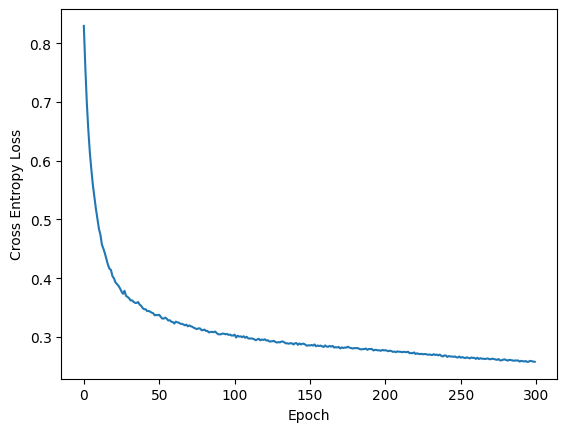

In [44]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch');

In [45]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
    
print(f"CE Loss: {loss:.8f}")

CE Loss: 0.25237864


In [46]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
        
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.4675, -2.0748])    0      0   
tensor([-3.1032,  3.0216])    1      0   
tensor([ 2.0281, -1.4716])    0      0   
tensor([-1.2069,  1.3599])    1      1   
tensor([ 2.3608, -1.7206])    0      0   
tensor([ 2.0821, -1.8283])    0      0   
tensor([ 1.7541, -1.2344])    0      0   
tensor([-1.7532,  0.9479])    1      1   
tensor([ 3.1282, -1.1172])    0      0   
tensor([-1.5939,  0.3794])    1      1   
tensor([ 2.1389, -1.5523])    0      0   
tensor([ 1.4811, -2.0988])    0      0   
tensor([ 1.2849, -1.2703])    0      0   
tensor([-2.0109,  1.3053])    1      1   
tensor([ 2.7408, -1.6589])    0      0   
tensor([-4.0618,  2.8833])    1      1   
tensor([ 2.3582, -1.9494])    0      1   
tensor([ 2.3581, -1.3220])    0      0   
tensor([ 0.9758, -0.6789])    0      0   
tensor([ 1.8525, -2.1406])    0      0   
tensor([-2.4659,  2.2204])    1      1   
tensor([-0.4065,  0.0928])    1      1   
tensor([-2.1295,  1.6905])    1   

In [47]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'taxi_fare_classifier.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [48]:
def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [49]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
loaded_model = TabularModel(emb_szs, 6, 2, [200,100], p=0.4)

In [50]:
loaded_model.load_state_dict(torch.load('taxi_fare_classifier.pt'));
loaded_model.eval() 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1864\1476403420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('taxi_fare_classifier

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [51]:
def test_data(model):
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])

    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = model(xcats, xconts).argmax().item()
        
    print(f"\nThe predicted fare class is {z}.")

In [52]:
test_data

What is the pickup latitude?   40.5
What is the pickup longitude?  -73.9
What is the dropoff latitude?   40.52
What is the dropoff longitude?  -73.92
How many passengers?  2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS      2010-04-15 16:00:00



The predicted fare class is 1.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1864\1768603628.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
